# 3.1 De batch a streaming

En esta sección comparamos dos enfoques sobre el conjunto de datos **Electricity (Elec2)**:

1. **Enfoque batch (Scikit-learn)**  
   - Convertimos el flujo de datos en un `DataFrame` de pandas.  
   - Entrenamos un `GaussianNB` de Scikit-learn sobre un subconjunto de entrenamiento.  
   - Evaluamos sobre un subconjunto de test, respetando el orden temporal (sin barajar).

2. **Enfoque streaming (River)**  
   - Entrenamos un `GaussianNB` de River de forma incremental.  
   - Evaluamos con *evaluación progresiva*: en cada instante predecimos primero y después actualizamos el modelo.

Finalmente comparamos las precisiones obtenidas.


In [1]:
import pandas as pd
from river import datasets

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from river import naive_bayes, metrics, preprocessing, compose, datasets, forest
import matplotlib.pyplot as plt
import numpy as np

## GaussianNB batch (Scikit-learn)

In [2]:
# 1) Convertir el flujo Elec2 a DataFrame de pandas
elec_stream = datasets.Elec2()

rows = []
for x, y in elec_stream:
    row = dict(x)
    row['target'] = y
    rows.append(row)

df_elec = pd.DataFrame(rows)
print("Shape del DataFrame:", df_elec.shape)
print(df_elec.head())

# 2) Separar X, y
X = df_elec.drop(columns=['target'])
y = df_elec['target']

# 3) Codificar variables categóricas (por ejemplo 'day')
X_encoded = pd.get_dummies(X)

# 4) Partición train/test respetando el orden (shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, shuffle=False
)

# 5) Entrenar GaussianNB batch de Scikit-learn
gnb_batch = GaussianNB()
gnb_batch.fit(X_train, y_train)

# 6) Evaluar
y_pred_test = gnb_batch.predict(X_test)
acc_batch = accuracy_score(y_test, y_pred_test)

print(f"Precisión GaussianNB (Scikit-learn, batch): {acc_batch:.4f}")

Shape del DataFrame: (45312, 9)
   date  day    period  nswprice  nswdemand  vicprice  vicdemand  transfer  \
0   0.0    2  0.000000  0.056443   0.439155  0.003467   0.422915  0.414912   
1   0.0    2  0.021277  0.051699   0.415055  0.003467   0.422915  0.414912   
2   0.0    2  0.042553  0.051489   0.385004  0.003467   0.422915  0.414912   
3   0.0    2  0.063830  0.045485   0.314639  0.003467   0.422915  0.414912   
4   0.0    2  0.085106  0.042482   0.251116  0.003467   0.422915  0.414912   

   target  
0    True  
1    True  
2    True  
3    True  
4   False  
Precisión GaussianNB (Scikit-learn, batch): 0.7539


## GaussianNB streaming (River, evaluación progresiva)

In [3]:
# Pipeline:
#  - Select('day') -> OneHotEncoder
#  - SelectType(float) -> deja pasar las numéricas tal cual
#  - GaussianNB final
oh_day = compose.Select('day') | preprocessing.OneHotEncoder()
nums  = compose.SelectType(float)

model_gnb_stream = (oh_day + nums) | naive_bayes.GaussianNB()
metric_stream = metrics.Accuracy()
progressive_acc_gnb = []

from time import time
start = time()

for i, (x, y) in enumerate(datasets.Elec2()):
    y_pred = model_gnb_stream.predict_one(x)
    metric_stream.update(y, y_pred)
    progressive_acc_gnb.append(metric_stream.get())
    model_gnb_stream.learn_one(x, y)

end = time()

print(f"Precisión final GaussianNB (River, progresiva): {metric_stream.get():.4f}")
print(f"Tiempo total: {end - start:.2f} s")

Precisión final GaussianNB (River, progresiva): 0.7258
Tiempo total: 12.22 s


## Comparación rápida batch vs streaming

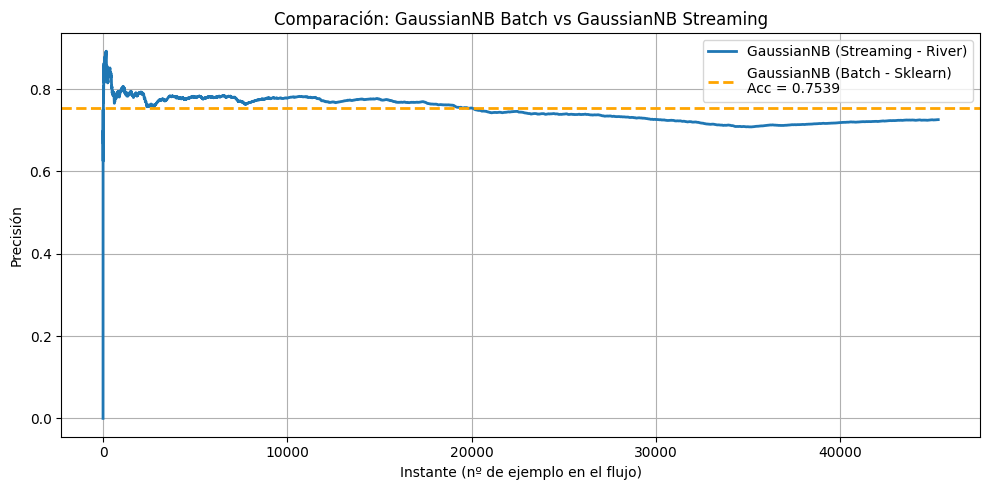

Precisión GaussianNB batch (Scikit-learn): 0.7539
Precisión final GaussianNB streaming (River): 0.7258


In [4]:
plt.figure(figsize=(10,5))

# --- Curva progresiva del modelo streaming ---
plt.plot(progressive_acc_gnb,
         label="GaussianNB (Streaming - River)",
         linewidth=2)

# --- Línea horizontal con la precisión batch ---
plt.axhline(y=acc_batch,
            color="orange",
            linestyle="--",
            linewidth=2,
            label=f"GaussianNB (Batch - Sklearn)\nAcc = {acc_batch:.4f}")

# Labels y título
plt.xlabel("Instante (nº de ejemplo en el flujo)")
plt.ylabel("Precisión")
plt.title("Comparación: GaussianNB Batch vs GaussianNB Streaming")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Precisión GaussianNB batch (Scikit-learn): {acc_batch:.4f}")
print(f"Precisión final GaussianNB streaming (River): {metric_stream.get():.4f}")

# 3.2 Manejo de *concept drift* con ADWIN

En esta parte integramos el detector de cambios **ADWIN** en el flujo de datos:

- Usamos un `GaussianNB` de River como clasificador base.
- Alimentamos a ADWIN con el error (0 si acierta, 1 si falla).
- Cuando ADWIN detecta un cambio relevante:
  - **Estrategia**: reiniciamos el modelo (lo re-inicializamos desde cero).
  - Guardamos el instante en el que se ha producido el *drift* para visualizarlo.

Así obtenemos una versión de GaussianNB que se “resetea” cuando cambia el concepto.


## GaussianNB + ADWIN

In [5]:
from river import drift

# Modelo base: GaussianNB con OneHotEncoder
def make_gnb_model():
    return compose.Pipeline(
        naive_bayes.GaussianNB()
    )

model_gnb_drift = make_gnb_model()
metric_gnb_drift = metrics.Accuracy()
adwin = drift.ADWIN()

progressive_acc_gnb_drift = []
drift_points = []

dataset_stream = datasets.Elec2()

for i, (x, y) in enumerate(dataset_stream):
    # Predicción antes de aprender
    y_pred = model_gnb_drift.predict_one(x)
    
    # Actualizar métrica
    metric_gnb_drift.update(y, y_pred)
    progressive_acc_gnb_drift.append(metric_gnb_drift.get())
    
    # Actualizar ADWIN con el error (1 si fallo, 0 si acierto)
    error = int(y_pred != y)
    adwin.update(error)
    
    # Si ADWIN detecta *drift*, reiniciamos el modelo
    if adwin.drift_detected:
        print(f"Drift detectado en t = {i}. Reiniciando modelo.")
        drift_points.append(i)
        model_gnb_drift = make_gnb_model()
        adwin = drift.ADWIN()
    
    # Aprendizaje
    model_gnb_drift.learn_one(x, y)

print(f"Precisión final GaussianNB + ADWIN: {metric_gnb_drift.get():.4f}")
print(f"Nº de drifts detectados: {len(drift_points)}")

Drift detectado en t = 223. Reiniciando modelo.
Drift detectado en t = 1663. Reiniciando modelo.
Drift detectado en t = 2239. Reiniciando modelo.
Drift detectado en t = 2431. Reiniciando modelo.
Drift detectado en t = 4383. Reiniciando modelo.
Drift detectado en t = 5087. Reiniciando modelo.
Drift detectado en t = 7231. Reiniciando modelo.
Drift detectado en t = 9311. Reiniciando modelo.
Drift detectado en t = 11583. Reiniciando modelo.
Drift detectado en t = 11903. Reiniciando modelo.
Drift detectado en t = 12575. Reiniciando modelo.
Drift detectado en t = 14143. Reiniciando modelo.
Drift detectado en t = 14815. Reiniciando modelo.
Drift detectado en t = 15263. Reiniciando modelo.
Drift detectado en t = 15711. Reiniciando modelo.
Drift detectado en t = 16159. Reiniciando modelo.
Drift detectado en t = 16543. Reiniciando modelo.
Drift detectado en t = 17311. Reiniciando modelo.
Drift detectado en t = 19071. Reiniciando modelo.
Drift detectado en t = 19807. Reiniciando modelo.
Drift det

## Comparar GNB “normal” vs GNB + ADWIN

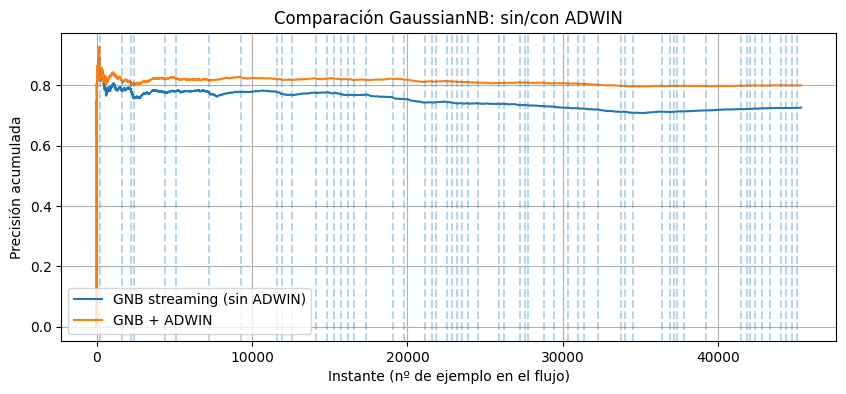

In [6]:
plt.figure(figsize=(10,4))
plt.plot(progressive_acc_gnb, label="GNB streaming (sin ADWIN)")
plt.plot(progressive_acc_gnb_drift, label="GNB + ADWIN")
for t in drift_points:
    plt.axvline(t, linestyle="--", alpha=0.3)  # línea vertical en cada drift

plt.xlabel("Instante (nº de ejemplo en el flujo)")
plt.ylabel("Precisión acumulada")
plt.title("Comparación GaussianNB: sin/con ADWIN")
plt.legend()
plt.grid(True)
plt.show()

# 3.3 Modelos adaptativos: HAT y Adaptive Random Forest

A continuación construimos modelos adaptativos en River:

- Un *pipeline* que combina:
  - `StandardScaler` (para normalizar atributos numéricos).
  - Un **Hoeffding Adaptive Tree (HAT)**.

- Un **Adaptive Random Forest (ARF)** que utiliza como árboles base modelos adaptativos.

Para ambos modelos generamos curvas de evaluación progresiva sobre el flujo `Elec2` y las comparamos.


## Función de evaluación progresiva

In [7]:
from river import tree, ensemble

def progressive_evaluation(model, dataset):
    """Evalúa un modelo River de forma progresiva sobre un dataset en flujo.
    
    Devuelve:
      - lista con la precisión acumulada en cada instante
      - métrica final (Accuracy)
    """
    metric = metrics.Accuracy()
    history = []
    
    for i, (x, y) in enumerate(dataset):
        y_pred = model.predict_one(x)
        metric.update(y, y_pred)
        history.append(metric.get())
        model.learn_one(x, y)
    
    return history, metric

## HAT (Hoeffding Adaptive Tree)

In [8]:
from river import preprocessing, compose

# Pipeline HAT: OneHotEncoder + StandardScaler + HAT
hat_model = compose.Pipeline(
    preprocessing.StandardScaler(),
    tree.HoeffdingAdaptiveTreeClassifier()
)

dataset_hat = datasets.Elec2()
acc_hat_history, acc_hat_metric = progressive_evaluation(hat_model, dataset_hat)

print(f"Precisión final HAT: {acc_hat_metric.get():.4f}")

Precisión final HAT: 0.8291


## Adaptive Random Forest (ARF)

In [9]:
# Pipeline ARF: StandardScaler + AdaptiveRandomForest
arf_model = compose.Pipeline(
    preprocessing.StandardScaler(),
    forest.ARFClassifier(
        n_models=10,      # nº de árboles en el bosque
        seed=42
    )
)

dataset_arf = datasets.Elec2()
acc_arf_history, acc_arf_metric = progressive_evaluation(arf_model, dataset_arf)

print(f"Precisión final ARF: {acc_arf_metric.get():.4f}")

Precisión final ARF: 0.8946


## Comparar curvas HAT vs ARF

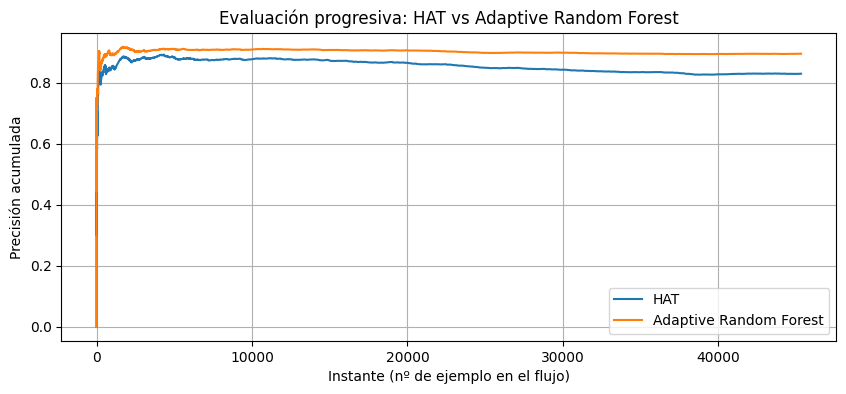

In [10]:
plt.figure(figsize=(10,4))
plt.plot(acc_hat_history, label="HAT")
plt.plot(acc_arf_history, label="Adaptive Random Forest")
plt.xlabel("Instante (nº de ejemplo en el flujo)")
plt.ylabel("Precisión acumulada")
plt.title("Evaluación progresiva: HAT vs Adaptive Random Forest")
plt.legend()
plt.grid(True)
plt.show()